# Module 3 Lab 2 - Linear Mixed-effects Models (LMM)

In prior courses you have likely learned how to create regression models that allow you to predict a dependent variable using one or more independent variables.  Those methods, linear regression, logistic regression, ordinary least squares, etc, had an assumption in common: the independent variables must be independent of each other.  The only dependency that was allowable was to the variable you were trying to predict.  

Of course, this assumption is not always possible to make, and in some cases, we may inadvertently ignore that some independent variables are actually related and use those methods anyways.  In cases where longitudinal data are included in the model, the independent variables are explicitly correlated.  We've explored other ways to handle this kind of related data, and here we will discuss another approach.  Linear Mixed-Effects Modeling can handle modeling linear relationships where the independent variables acutally have some dependency.

In this lab, we will learn how to run such a model.

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import sys
!{sys.executable} -m pip install --upgrade "statsmodels==0.11"

import statsmodels.api as sm

Requirement already up-to-date: statsmodels==0.11 in /opt/conda/lib/python3.7/site-packages (0.11.0)


## Data

3 female and 4 male trained athletes were asked to perform 7 exercise routines in both cool and warm conditions.  Their maximum heart rate was recorded for each of the trials.

    * subject - a subject identifier
    * gender - M for male, F for female
    * scenario - 1-7 for each exercise scenario
    * temp - warm or cool for the temperature condition of the exercise
    * hr - the maximum attained heart rate during the exercise

We want to analyze this data to understand if there is a relationship between maximum heart rate during exercise and temperature.  Because we took seven measurements per subject, the data have dependencies, therefore we cannot apply traditional linear regression. In addition to this dependent data, we have a fixed effect of gender, and an additional variable of temperature. We will use a mixed effects model to handle this analysis.

First we will load the data and look at the heart rate in box plots by the different variables in our data set.

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 5]

data=pd.read_csv('../resources/exercise.csv')
data = data.dropna(how='any')

display(data)


,subject,gender,scenario,temp,hr
0,F1,F,1,warm,137
1,F1,F,1,cool,143
2,F1,F,2,warm,174
3,F1,F,2,cool,191
4,F1,F,3,warm,193
...,...,...,...,...,...
78,M7,M,5,cool,126
79,M7,M,6,warm,145
80,M7,M,6,cool,145
81,M7,M,7,warm,166


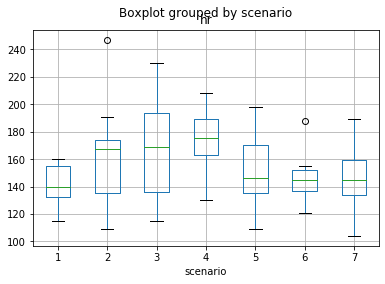

In [3]:
data.boxplot(column='hr', by='scenario')

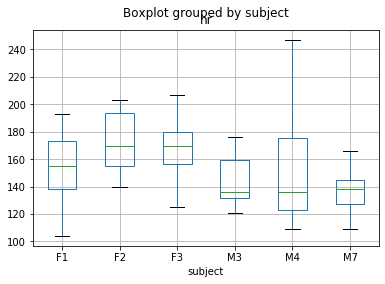

In [4]:
data.boxplot(column='hr', by='subject')

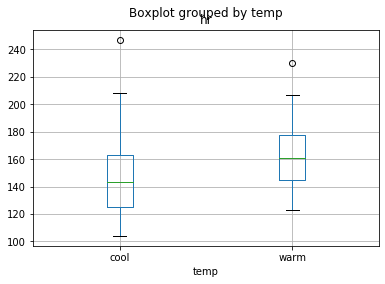

In [5]:
data.boxplot(column='hr', by='temp')

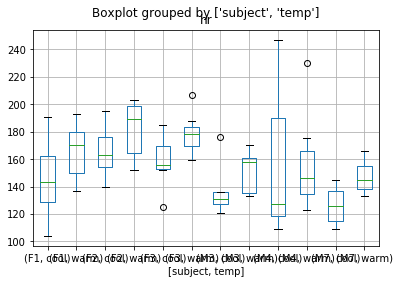

In [6]:
data.boxplot(column='hr', by=['subject','temp'])

## From linear regression to Generalized Estimating Equations to Linear Mixed-effects Models

Recall that in ordinary least squares (OLS) linear regression, we specify a model that is comprised of one dependent variable and one or more independent variables.  For the data file above, we might naively try a model such as:

`hr ~ gender + C(temp) + C(scenario) `

However, this model is incorrect because of the independency assumption of OLS.  Because each subject has 7 different heart rates recorded, there is a dependency of the variable hr within each subject.

In prior labs we covered Generalized Estimating Equations as well as Repeated Measures ANOVA.  Each of these methods has a place in modeling dependent data, and provide different interpretations:

  * ANOVARM - Is there a significant difference in the means of the different groups or time points
  * GEE - Provides a model that accounts for dependencies but returns average effects across all subjects with a correction for the dependence
  
With LMM, we get benefit the of GEE's handling of dependencies between the predictor variables, but rather than apply a correction to a global set of parameter estimates, LMM will subdivide the data into clusters, and compute cluster specific parameters which are then brought together in a weighted fashion to form the final model.

The difference can be visualized clearly in the below animation of [Simpson's Paradox](https://www.britannica.com/topic/Simpsons-paradox)


<img src='../resources/Simpsons_paradox_-_animation.gif'/>
(By Pace~svwiki - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=62007681)

In the animation, we see 5 clusters of data with positive trends (slopes); however, when taken as a whole, the trend is negative.  In a GEE, the negative slope would be represented, because it's answering the question of _overall_ trend while accounting for interdependent data, whereas LMM will represent positive slopes for the individual clusters and ignore the overall trend.

Clearly you can see that the choice of model depends on the question you wish to answer as well as what your data supports.

Lets move on to how we might apply LMM's to our heart rate data.

## Modeling heart rate data
We'll start by modeling the heart rate data accounting for the variable `temp`.  Our goal is to provide a model that accounts for the dependence of the data within a subject.  The first model we will apply is the simplest mixed model, one with a single fixed effect and a single random effect.

The fixed effect is the independent variable, and the random effect is meant to model the variance within a cluster.

Here is the model specified in mathematical notation:

$\huge Y_{ij} = \beta_0 + \beta_{1}X + \mu_i + \epsilon_{ij}$

This resembles a regular linear regression model, but with some extra terms and differences.

First, some terms are subscripted:

  * i - represents a cluster
  * j - represents an observation
  
So, within clusters 1..i, we can have observations 1..j.  The result of the regression is a prediction for a particular observation j within a cluster i.

In addition to the fixed intercept we are used to seeing in OLS regression ($\beta_0$) and the coefficient for our fixed variable ($\beta_{1}X$), we also have a random intercept $\mu_i$, which represents the variation for each cluster, and finally the error term $\epsilon_{ij}$, which represents the residual for each observation j nested with cluster i.

So you can see that, unlike an OLS regression model which can be represented with only simple real numbers for the $\beta$ parameters, a LMM also needs matrix structures to represent these additional terms.

Below we will use statsmodels to fit this simple LMM. 

In [7]:
# create a model with a single random intercept

model = sm.MixedLM.from_formula('hr ~ C(temp)',
                                 groups='subject', data=data)
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   hr       
No. Observations:   83        Method:               REML     
No. Groups:         6         Scale:                623.3206 
Min. group size:    13        Log-Likelihood:       -383.0004
Max. group size:    14        Converged:            Yes      
Mean group size:    13.8                                     
-------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       147.935    6.402 23.106 0.000 135.386 160.483
C(temp)[T.warm]  15.494    5.483  2.826 0.005   4.748  26.240
subject Var     154.617    5.207                             



## Interpretation 
Interpretation of the model is similar to that for OLS.  The base heart rate is the intercept (147.935).  When the tempearture is `warm`, the base hr goes up by 15.494.

There is an additional parameter labeled `subject Var` in the output.  This is the variance of the random effect for `subject`, meaning the standard deviation is approximately 12.43 (the square root of 154.617).  Recall that one standard deviation from the mean accounts for about 68% of the data.  So, about 68% of the random intercepts by subject are $\pm$ 12.43 from the fixed intercept for heart rate, plus any adjustment by other fixed variables.

The `Scale` values gives us the error variance for the model, which is the variance of the difference between the predicted and actual heart rates.  If you convert to the standard deviation you will know that about 68% of the differences between the fitted and actual heart rates are within 24.97.

Recall the random effect for the simple mixied-effect model that we fitted:

$\large hr_{ij} = \beta_0 + \beta_{1}temp + \mu_i + \epsilon_{ij}$

$\mu_i$ indicates that there is a group specific mean applied to the model, and we can see what those are:


In [8]:
pprint(result.random_effects)

{'F1': subject   -0.030051
dtype: float64,
 'F2': subject    13.834665
dtype: float64,
 'F3': subject    10.063462
dtype: float64,
 'M3': subject   -9.513517
dtype: float64,
 'M4': subject    0.316632
dtype: float64,
 'M7': subject   -14.671192
dtype: float64}


We have a different mean intercept for each of the members in the group, which represent the random effect of the model.  So, for subject `F1`, the mean heart rate is reduced by 0.03, for `F2` it is increased by 13.83, and so on.  

Now, in our model we only specified temp as a predictor, but we also have gender, and based on our boxplots from above we can see that there is a difference in heart rate by gender, so we will fit a LMM including gender next.

In [9]:
model = sm.MixedLM.from_formula('hr ~ C(temp) + C(gender)',
                                 groups='subject', data=data)
result = model.fit()
print(result.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   hr       
No. Observations:   83        Method:               REML     
No. Groups:         6         Scale:                623.6169 
Min. group size:    13        Log-Likelihood:       -377.5542
Max. group size:    14        Converged:            Yes      
Mean group size:    13.8                                     
-------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       158.115    6.103 25.907 0.000 146.153 170.077
C(temp)[T.warm]  15.626    5.485  2.849 0.004   4.877  26.376
C(gender)[T.M]  -20.626    7.736 -2.666 0.008 -35.788  -5.465
subject Var      44.640    2.622                             



In these results we can see that adding gender, which is a significant independent variable, reduced the random effect variance considerably, leading to a better model, because more of the within-subject uncertainty in the model was explained by gender.  However, the overall error variance did not change much.

Next, we will fit a _crossed_ random effects model.  A crossed random effects model means that we build a model accounting for two groups.  This is represented in formula as:

$\huge Y_{ij} = \beta_0 + \beta_{1}X + \mu{1}_i + \mu{2}_i + \epsilon_{ij}$

Now you can see that we have two random intercepts added to the model, and each one is treated independently.  This allows the model to control for two random effects at the intercept level.  In our case, we will add the `scenario` as a second random intercept.  Recall that each of the subjects in the study were asked to perform seven different exercises.  Based on the box plot, we can see that there is some variablility in those, so adding a second random intercept will help with modeling the data.

In statsmodels, we create a dictionary describing our two random intercepts, and pass a constant group feature to the MixedLM method.  This is an artifact of the implementation in statsmodels. In R, the implementation is more robust and straightforward.


In [10]:
# create a model with two random intercepts (a crossed random effects model)
data['group'] = 0 # add a constant group which will be used when doing a crossed effects model

vcf = {"subject": "0 + C(subject)", "scenario": "0 + C(scenario)"}
model = sm.MixedLM.from_formula(
    "hr ~ temp + C(gender)",
    groups='group',
    vc_formula=vcf,
    data=data)

result = model.fit()
print(result.summary())
print()
pprint(result.random_effects)

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  hr       
No. Observations:    83       Method:              REML     
No. Groups:          1        Scale:               504.1692 
Min. group size:     83       Log-Likelihood:      -373.5784
Max. group size:     83       Converged:           Yes      
Mean group size:     83.0                                   
------------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      158.024    7.294 21.665 0.000 143.728 172.319
temp[T.warm]    15.810    4.934  3.204 0.001   6.140  25.479
C(gender)[T.M] -20.810    7.607 -2.736 0.006 -35.719  -5.900
scenario Var   128.433    4.576                             
subject Var     50.290    2.821                             


{0: scenario[C(scenario)[1]]   -10.818192
scenario[C(scenario)[2]]     4.691471
scenario[C(scen

This model produced a slightly higher variance for subject, and the variance for scenario is not too high.  The overall error variance went down signficantly, so more of the overall uncertaintly was explained by adding scenario as a crossed effect.

We can test if the relationship is different for subjects and scenarios by looking at a _hierarchical_ model for random intercepts.  In such a model, the intercept of a lower level in the hierarchy depends upon the higher level.

In [11]:
# create a model with a hierarchical random intercept

vcf = {"scenario": "0 + C(scenario)"}
model = sm.MixedLM.from_formula(
    "hr ~ temp + C(gender)",
    groups='subject',
    vc_formula=vcf,
    data=data)

result = model.fit()
print(result.summary())
pprint(result.random_effects)


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  hr       
No. Observations:    83       Method:              REML     
No. Groups:          6        Scale:               525.8946 
Min. group size:     13       Log-Likelihood:      -377.2925
Max. group size:     14       Converged:           Yes      
Mean group size:     13.8                                   
------------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      158.034    5.005 31.574 0.000 148.224 167.844
temp[T.warm]    15.789    5.041  3.132 0.002   5.909  25.670
C(gender)[T.M] -20.789    6.146 -3.383 0.001 -32.834  -8.744
scenario Var   129.730    5.388                             

{'F1': scenario[C(scenario)[1]]    -8.566083
scenario[C(scenario)[2]]     5.474742
scenario[C(scenario)[3]]    -0.471960
scenario[C(scenario)[4]]     3.82288

This model has more overall uncertainty than the previous model, but a little less uncertainty within the subject-scenario hierarchy.  From the output of the random effects intercepts, you can get a sense of how the hierarchy accounts for differences by subject and scenario in the model.

Ultimately, which final model is chosen depends on whether you believe that effects for scenario are dependent on the subject or not.  One could make a case that some athletes may be more or less capable of performing some exercises than others, in which case the last model would be appropriate.  

## Comparing models: AIC and likelihood ratio tests
To get an objective comparison of models we can turn to two methods.  The first is to apply the AIC and compare across fitted models, and the second is to use the likelihood ratio test.

The AIC can be used to identify the best model under the AIC assumptions (explaining the most variance with the fewest features), as you would do for normal linear regression, and the likelihood ratio test can be used to derive a p-value to confirm a statistically significant difference in models.

### Likelihood ratio test (lr test)
Likelihood is the probability of seeing the data you collected given your model.  For the lr test, we specify two models.

To perform the likelihood ratio test, we must specify the null model as the model without the effect in question. We then specify a full model that includes the effect in question.  This is like the null hypothesis, if the p value is significant then we reject that the null model is equivalent to the full model, and select the full model.

To do both the AIC and the lr test, we must re-fit our models and specify that we do not want to use the random effects maximum likelihood method (REML) when fitting.  The REML method does not provide for log likelihoods that can be compared across models, and will not produce an AIC.

Lets determine if the model with gender is significantly better than the model without using AIC first, capture the log likelihoods for each, and finally perform the lr test.

(Note that you may see warning about failure to fit with lbfgs, which is ok, as statsmodels will try a different algorithm until it finds one that converges)


In [12]:
model = sm.MixedLM.from_formula('hr ~ C(temp)', groups='subject', data=data)
result = model.fit(reml=False)
llf_null = result.llf
print('Null model')
print('AIC', result.aic)
print('llf', llf_null)
print()

model = sm.MixedLM.from_formula('hr ~ C(temp) + C(gender)', groups='subject', data=data)
result = model.fit(reml=False)
llf_full = result.llf
print('Full model')
print('AIC', result.aic)
print('llf', llf_full)
print()




/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


Null model
AIC 784.515318749561
llf -388.2576593747805

Full model
AIC 780.8337968151789
llf -385.41689840758943



/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


In [13]:
# define a function to perform the lr test and return the p value
from scipy import stats
def lrtest(llf_null, llf_full):
    lr = 2 * (llf_full - llf_null)
    p = stats.chi2.sf(lr, 1) # chisquared test with one degree of freedom
    return lr, p # return the likelihood ratio and the p value from the chisquared test


print('Likelihood ratio test', lrtest(llf_null, llf_full))

Likelihood ratio test (5.68152193438209, 0.01714448990167814)


## Interpretation
Since the p value is below $\alpha$ = 0.05, at this significance level we reject the null model and accept the full model as the better fit.  The AIC of the full model is also lower, which corroborates this result.